In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

from sklearn.datasets import make_classification
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, roc_auc_score

from sklearn import tree

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV


In [2]:
df = pd.read_csv('train_subset_1.csv')

/tmp/ipykernel_1144/4179557144.py:1: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('train_subset_1.csv')


# Data Processing

In [3]:
# Remove columns with over 10% missing data
missing_cols = df.columns[df.isna().mean() >= 0.1]
df.drop(missing_cols, axis=1, inplace=True)
df.reset_index(inplace=True, drop=True)

In [4]:
idx = 'MachineIdentifier'
many_categorical_variables = ['EngineVersion', 'AppVersion', 'AvSigVersion', 'AVProductStatesIdentifier',
            'CountryIdentifier', 'CityIdentifier', 'GeoNameIdentifier', 'LocaleEnglishNameIdentifier', 'OsVer',
            'OsBuild', 'OsSuite', 'OsPlatformSubRelease', 'OsBuildLab', 'IeVerIdentifier', 'Census_MDC2FormFactor', 
            'Census_OEMNameIdentifier', 'Census_OEMModelIdentifier', 'Census_ProcessorModelIdentifier', 'Census_ChassisTypeName', 
            'Census_PowerPlatformRoleName', 'Census_OSVersion', 'Census_OSBranch', 'Census_OSBuildNumber', 'Census_OSBuildRevision',
            'Census_OSEdition', 'Census_OSSkuName', 'Census_OSInstallTypeName', 'Census_OSInstallLanguageIdentifier', 
            'Census_OSUILocaleIdentifier', 'Census_FlightRing', 'Census_FirmwareManufacturerIdentifier', 'Census_FirmwareVersionIdentifier', 
            'Wdft_RegionIdentifier']

few_categorical_variables = ['ProductName', 'Platform', 'Processor', 'SkuEdition', 'UacLuaenable', 'Census_DeviceFamily', 
            'Census_ProcessorManufacturerIdentifier', 'Census_PrimaryDiskTypeName', 'Census_OSArchitecture', 'Census_OSWUAutoUpdateOptionsName',
            'Census_GenuineStateName', 'Census_ActivationChannel']

binary_variables = ['IsBeta', 'IsSxsPassiveMode', 'HasTpm', 'IsProtected', 'AutoSampleOptIn', 'SMode', 'Firewall', 
            'Census_HasOpticalDiskDrive', 'Census_IsPortableOperatingSystem', 'Census_IsFlightsDisabled', 'Census_IsSecureBootEnabled',
            'Census_IsVirtualDevice', 'Census_IsTouchEnabled', 'Census_IsPenCapable', 'Census_IsAlwaysOnAlwaysConnectedCapable',
            'Wdft_IsGamer']

ordered_variables = ['AVProductsInstalled', 'AVProductsEnabled', 'RtpStateBitfield', 'Census_ProcessorCoreCount', 
            'Census_PrimaryDiskTotalCapacity', 'Census_SystemVolumeTotalCapacity', 'Census_TotalPhysicalRAM', 
            'Census_InternalPrimaryDiagonalDisplaySizeInInches', 'Census_InternalPrimaryDisplayResolutionHorizontal', 
            'Census_InternalPrimaryDisplayResolutionVertical', 'Census_InternalBatteryNumberOfCharges']

response = 'HasDetections'

In [5]:
# Make all lowercase
str_columns = df.dtypes[df.dtypes == 'object'].index
for col in str_columns:
    df[col] = df[col].str.lower()

In [6]:
# Remove columns with a single category with over 98.5% of the entries
max_tolerance = 0.015
imbalanced_cols = []
for col in df.columns:
    if (df[col].value_counts(dropna=False) / len(df) >= (1 - max_tolerance) ).any():
        imbalanced_cols.append(col)
        
df.drop(imbalanced_cols, axis=1, inplace=True)

In [7]:
categorical_variables = many_categorical_variables + few_categorical_variables
new_categorical_variables = set.intersection(set(categorical_variables), set(df.columns))

# Cast categorical columns with low-represented categories to "other"
min_tolerance = 0.001
imbalanced_categories = []
x = 0
for col in list(new_categorical_variables):
    #print(col)
    val_counts = df[col].value_counts(dropna=False)
    scarce_indices = (val_counts[(val_counts / len(df)) <= min_tolerance]).index
        
    map_dict = {}
    for item in scarce_indices:
        map_dict[item] = 'other'
    new_df_col = df[col].map(lambda x: map_dict.get(x,x))
    df[col] = new_df_col.copy()

    x += 1
    #print(x / len(new_categorical_variables))

In [8]:
df.dropna(inplace=True)

In [9]:
df.reset_index(inplace=True, drop=True)

# Model Fitting

In [10]:
y = df['HasDetections']
X = df.drop(['MachineIdentifier', 'HasDetections'], axis=1)

X.drop(['CountryIdentifier', 'CityIdentifier', 'GeoNameIdentifier', 'LocaleEnglishNameIdentifier', 'Census_OEMModelIdentifier', 'Census_ProcessorModelIdentifier', 'Census_OSVersion',
            'Census_FirmwareVersionIdentifier', 'AvSigVersion'], axis = 1, inplace=True)
X_dummies = pd.get_dummies(X)
X_dummies

,RtpStateBitfield,IsSxsPassiveMode,AVProductsInstalled,AVProductsEnabled,IsProtected,SMode,Firewall,Census_ProcessorCoreCount,Census_PrimaryDiskTotalCapacity,Census_SystemVolumeTotalCapacity,...,Wdft_RegionIdentifier_6.0,Wdft_RegionIdentifier_7.0,Wdft_RegionIdentifier_8.0,Wdft_RegionIdentifier_9.0,Wdft_RegionIdentifier_10.0,Wdft_RegionIdentifier_11.0,Wdft_RegionIdentifier_12.0,Wdft_RegionIdentifier_13.0,Wdft_RegionIdentifier_15.0,Wdft_RegionIdentifier_other
0,7.0,0.0,2.0,2.0,1.0,0.0,1.0,4.0,476940.0,102401.0,...,0,1,0,0,0,0,0,0,0,0
1,7.0,0.0,2.0,1.0,1.0,0.0,1.0,4.0,953869.0,102401.0,...,0,1,0,0,0,0,0,0,0,0
2,7.0,0.0,3.0,1.0,1.0,0.0,1.0,4.0,953869.0,913014.0,...,0,0,0,0,0,0,0,0,1,0
3,7.0,0.0,1.0,1.0,1.0,0.0,1.0,2.0,953869.0,305062.0,...,0,1,0,0,0,0,0,0,0,0
4,7.0,0.0,1.0,1.0,1.0,0.0,1.0,4.0,29600.0,28482.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443944,7.0,0.0,2.0,1.0,1.0,0.0,1.0,2.0,476940.0,475948.0,...,0,0,0,0,1,0,0,0,0,0
443945,7.0,0.0,1.0,1.0,1.0,0.0,1.0,4.0,953869.0,952984.0,...,0,0,0,0,0,0,0,0,0,0
443946,7.0,0.0,2.0,1.0,1.0,0.0,1.0,2.0,953869.0,926992.0,...,0,0,0,0,1,0,0,0,0,0
443947,7.0,0.0,2.0,1.0,1.0,0.0,1.0,4.0,953869.0,952728.0,...,0,0,0,0,0,0,0,0,0,0


## RF Model

In [44]:
param_grid = {
    'bootstrap': [False],
    'max_depth': [25],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [5, 10, 15],
    'n_estimators': [30,35,40,45,50]
}

In [46]:
rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
grid_search.fit(X_dummies[0:100000], y[0:100000])

Fitting 3 folds for each of 90 candidates, totalling 270 fits
[CV] END bootstrap=False, max_depth=25, max_features=2, min_samples_leaf=3, min_samples_split=5, n_estimators=30; total time=  11.1s
[CV] END bootstrap=False, max_depth=25, max_features=2, min_samples_leaf=3, min_samples_split=5, n_estimators=30; total time=  11.6s
[CV] END bootstrap=False, max_depth=25, max_features=2, min_samples_leaf=3, min_samples_split=5, n_estimators=30; total time=  12.2s
[CV] END bootstrap=False, max_depth=25, max_features=2, min_samples_leaf=3, min_samples_split=5, n_estimators=35; total time=  12.5s
[CV] END bootstrap=False, max_depth=25, max_features=2, min_samples_leaf=3, min_samples_split=5, n_estimators=35; total time=  13.0s
[CV] END bootstrap=False, max_depth=25, max_features=2, min_samples_leaf=3, min_samples_split=5, n_estimators=35; total time=  13.8s
[CV] END bootstrap=False, max_depth=25, max_features=2, min_samples_leaf=3, min_samples_split=5, n_estimators=40; total time=  14.2s
[CV] EN

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [False], 'max_depth': [25],
                         'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [5, 10, 15],
                         'n_estimators': [30, 35, 40, 45, 50]},
             verbose=2)

In [47]:
grid_search.best_params_

{'bootstrap': False,
 'max_depth': 25,
 'max_features': 3,
 'min_samples_leaf': 4,
 'min_samples_split': 15,
 'n_estimators': 45}

In [12]:
rf = RandomForestClassifier(n_estimators = 45, max_depth=25, random_state=0, min_samples_leaf=4, min_samples_split=15)
rf.fit(X_dummies[0:100000], y[0:100000])

RandomForestClassifier(max_depth=25, min_samples_leaf=4, min_samples_split=15,
                       n_estimators=45, random_state=0)

In [13]:
y_pred_train_xgb = rf.predict_proba(X_dummies[0:100000])
rf_predict_train_ones = y_pred_train_xgb[:,1]

y_pred_test_xgb = rf.predict_proba(X_dummies[200000:250000])
rf_predict_test_ones = y_pred_test_xgb[:,1]

y_train = y[0:100000]
y_test = y[200000:250000]

auc_train = roc_auc_score(y_train, rf_predict_train_ones)
auc_test = roc_auc_score(y_test, rf_predict_test_ones)
print("training auc: " , auc_train)
print("testing auc: " ,auc_test)

training auc:  0.7974359482086044
testing auc:  0.6635140113841181


In [14]:
feature_importances = rf.feature_importances_
importance_df = pd.DataFrame({'Feature': X_dummies.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

                                               Feature  Importance
105                  AVProductStatesIdentifier_53447.0    0.055119
2                                  AVProductsInstalled    0.043475
9                     Census_SystemVolumeTotalCapacity    0.042580
12   Census_InternalPrimaryDiagonalDisplaySizeInInches    0.030110
8                      Census_PrimaryDiskTotalCapacity    0.025761
..                                                 ...         ...
281                    Census_OEMNameIdentifier_5771.0    0.000000
189  OsBuildLab_7601.24214.amd64fre.win7sp1_ldr_esc...    0.000000
280                    Census_OEMNameIdentifier_5682.0    0.000000
205                               IeVerIdentifier_71.0    0.000000
118                                    Processor_other    0.000000

[589 rows x 2 columns]


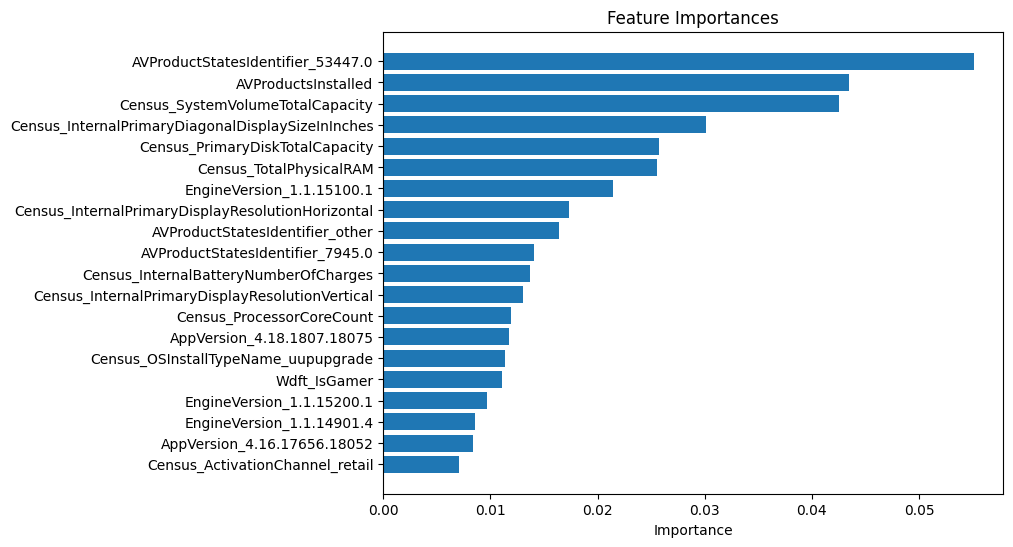

In [15]:
plt.figure(figsize=(8, 6))
plt.barh(importance_df['Feature'].iloc[:20][::-1], importance_df['Importance'].iloc[:20][::-1])
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()

In [107]:
top_20_features_rf = importance_df['Feature'].iloc[:20].tolist()
top_20_features_rf

['Census_SystemVolumeTotalCapacity',
 'Census_InternalPrimaryDiagonalDisplaySizeInInches',
 'AVProductStatesIdentifier_53447.0',
 'Census_PrimaryDiskTotalCapacity',
 'Census_TotalPhysicalRAM',
 'AVProductsInstalled',
 'Census_InternalPrimaryDisplayResolutionHorizontal',
 'EngineVersion_1.1.15100.1',
 'Census_InternalPrimaryDisplayResolutionVertical',
 'Census_InternalBatteryNumberOfCharges',
 'Census_ProcessorCoreCount',
 'Wdft_IsGamer',
 'Census_OSInstallTypeName_UUPUpgrade',
 'AppVersion_4.18.1807.18075',
 'AVProductStatesIdentifier_other',
 'EngineVersion_1.1.15200.1',
 'AVProductStatesIdentifier_7945.0',
 'Census_ActivationChannel_Retail',
 'Census_OSInstallLanguageIdentifier_8.0',
 'Census_IsSecureBootEnabled']

## XGBoost

In [14]:
dtrain = xgb.DMatrix(X_dummies[0:100000], label=y[0:100000])
dtest = xgb.DMatrix(X_dummies[200000:250000], label=y[200000:250000])

: 

In [12]:
# params = {
#     'objective': 'binary:logistic',  # for binary classification problems
#     'max_depth': 3,
#     'learning_rate': 0.1,
#     'eval_metric': 'auc'
# }
params = {
        'min_child_weight': [5],
        'gamma': [0.5, 1, 1.5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.1]
        }
num_rounds = 3000  # Number of boosting rounds (iterations)

In [11]:
# xgb_model = xgb.train(params, dtrain, num_rounds)
xgb = XGBClassifier(n_estimators=200, objective='binary:logistic', silent=1, nthread=1)
grid_search = GridSearchCV(estimator = xgb, param_grid = params, 
                          cv = 3, n_jobs = -1, verbose = 2)
# random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=20, scoring='roc_auc', n_jobs=-1, cv=3, verbose=2, random_state=42)
grid_search.fit(X_dummies[0:100000], y[0:100000])

NameError: name 'params' is not defined

In [ ]:
random_search.best_params_

In [127]:
y_pred_xgb = xgb_model.predict(dtest)

# For binary classification
y_pred_xgb_binary = [1 if p > 0.5 else 0 for p in y_pred_xgb]

auc = roc_auc_score(y_test, y_pred_xgb)
acc = accuracy_score(y_test, y_pred_xgb_binary)
print(f'AUC: {auc:.4f}')
print(f'ACC: {acc:.4f}')

AUC: 0.6714
ACC: 0.6249


# Tree

In [11]:
dtree_model = tree.DecisionTreeClassifier()
dtree_model.fit(X_dummies[0:10000], y[0:10000])

DecisionTreeClassifier()

In [12]:
#predictions = dtree.predict(X_dummies[200000:250000])
auc = roc_auc_score(y[20000:25000], dtree_model.predict_proba(X_dummies[20000:25000])[:, 1])
print(f'AUC: {auc}')

AUC: 0.5487421798864975


In [29]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4]
}

grid_search = GridSearchCV(dtree_model, param_grid, scoring='roc_auc', cv=5, n_jobs=-1)
grid_search.fit(X_dummies[0:100000], y[0:100000])

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7, 10], 'min_samples_leaf': [2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='roc_auc')

In [14]:
best_params = grid_search.best_params_
best_clf = grid_search.best_estimator_

In [30]:
tree_pred = best_clf.predict_proba(X_dummies[200000:250000])[:, 1]

In [50]:
auc_grid = roc_auc_score(y[200000:250000], best_clf.predict_proba(X_dummies[200000:250000])[:, 1])
print(f'AUC: {auc_grid}')

AUC: 0.6166418691700607


# LogReg

In [119]:
# model = DecisionTreeClassifier()
model = LogisticRegression(penalty='l1', solver='liblinear')
model.fit(X_dummies[0:10000], y[0:10000])

/home/nuobeiz/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LogisticRegression(penalty='l1', solver='liblinear')

In [126]:
y_pred_log = model.predict(X_dummies[200000:250000])
y_pred_log_binary = [1 if p > 0.5 else 0 for p in y_pred_log]

auc = roc_auc_score(y_test, y_pred_log)
acurracy = accuracy_score(y_test, y_pred_log_binary)
print(f'AUC: {auc:.4f}')
print(f'acurracy: {acurracy:.4f}')

AUC: 0.6087
acurracy: 0.6092


## Soft Voting and Hard Voting

In [50]:
soft_voting = (rf_predict_test_ones+y_pred_xgb)/2
auc = roc_auc_score(y_test, soft_voting)
auc

ValueError: operands could not be broadcast together with shapes (50000,) (50000,2) 